# Preparing data and importing and installing necessary packages

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, backend, Input
from keras.applications.resnet import ResNet50

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

#Load data
dir = '/content/drive/MyDrive/advanced-ds-project/archive/Cutout Files'
class_names = ['galaxy', 'star']
data = image_dataset_from_directory(directory = dir,
                                    labels = 'inferred',
                                    label_mode = 'categorical',
                                    class_names = class_names)

Found 3986 files belonging to 2 classes.


In [4]:
print('Number of batches of data:', len(data))

Number of batches of data: 125


In [5]:
#Split data into training, validation, and test sets
train_validation = data.take(100)
train = train_validation.take(75)
valid = train_validation.skip(75)
test = data.skip(100)

# Data preprocessing and metrics

In [6]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                         layers.experimental.preprocessing.RandomRotation(0.5)])
train_augmented = train
for image, label in train_augmented:
  image = data_augmentation(image)

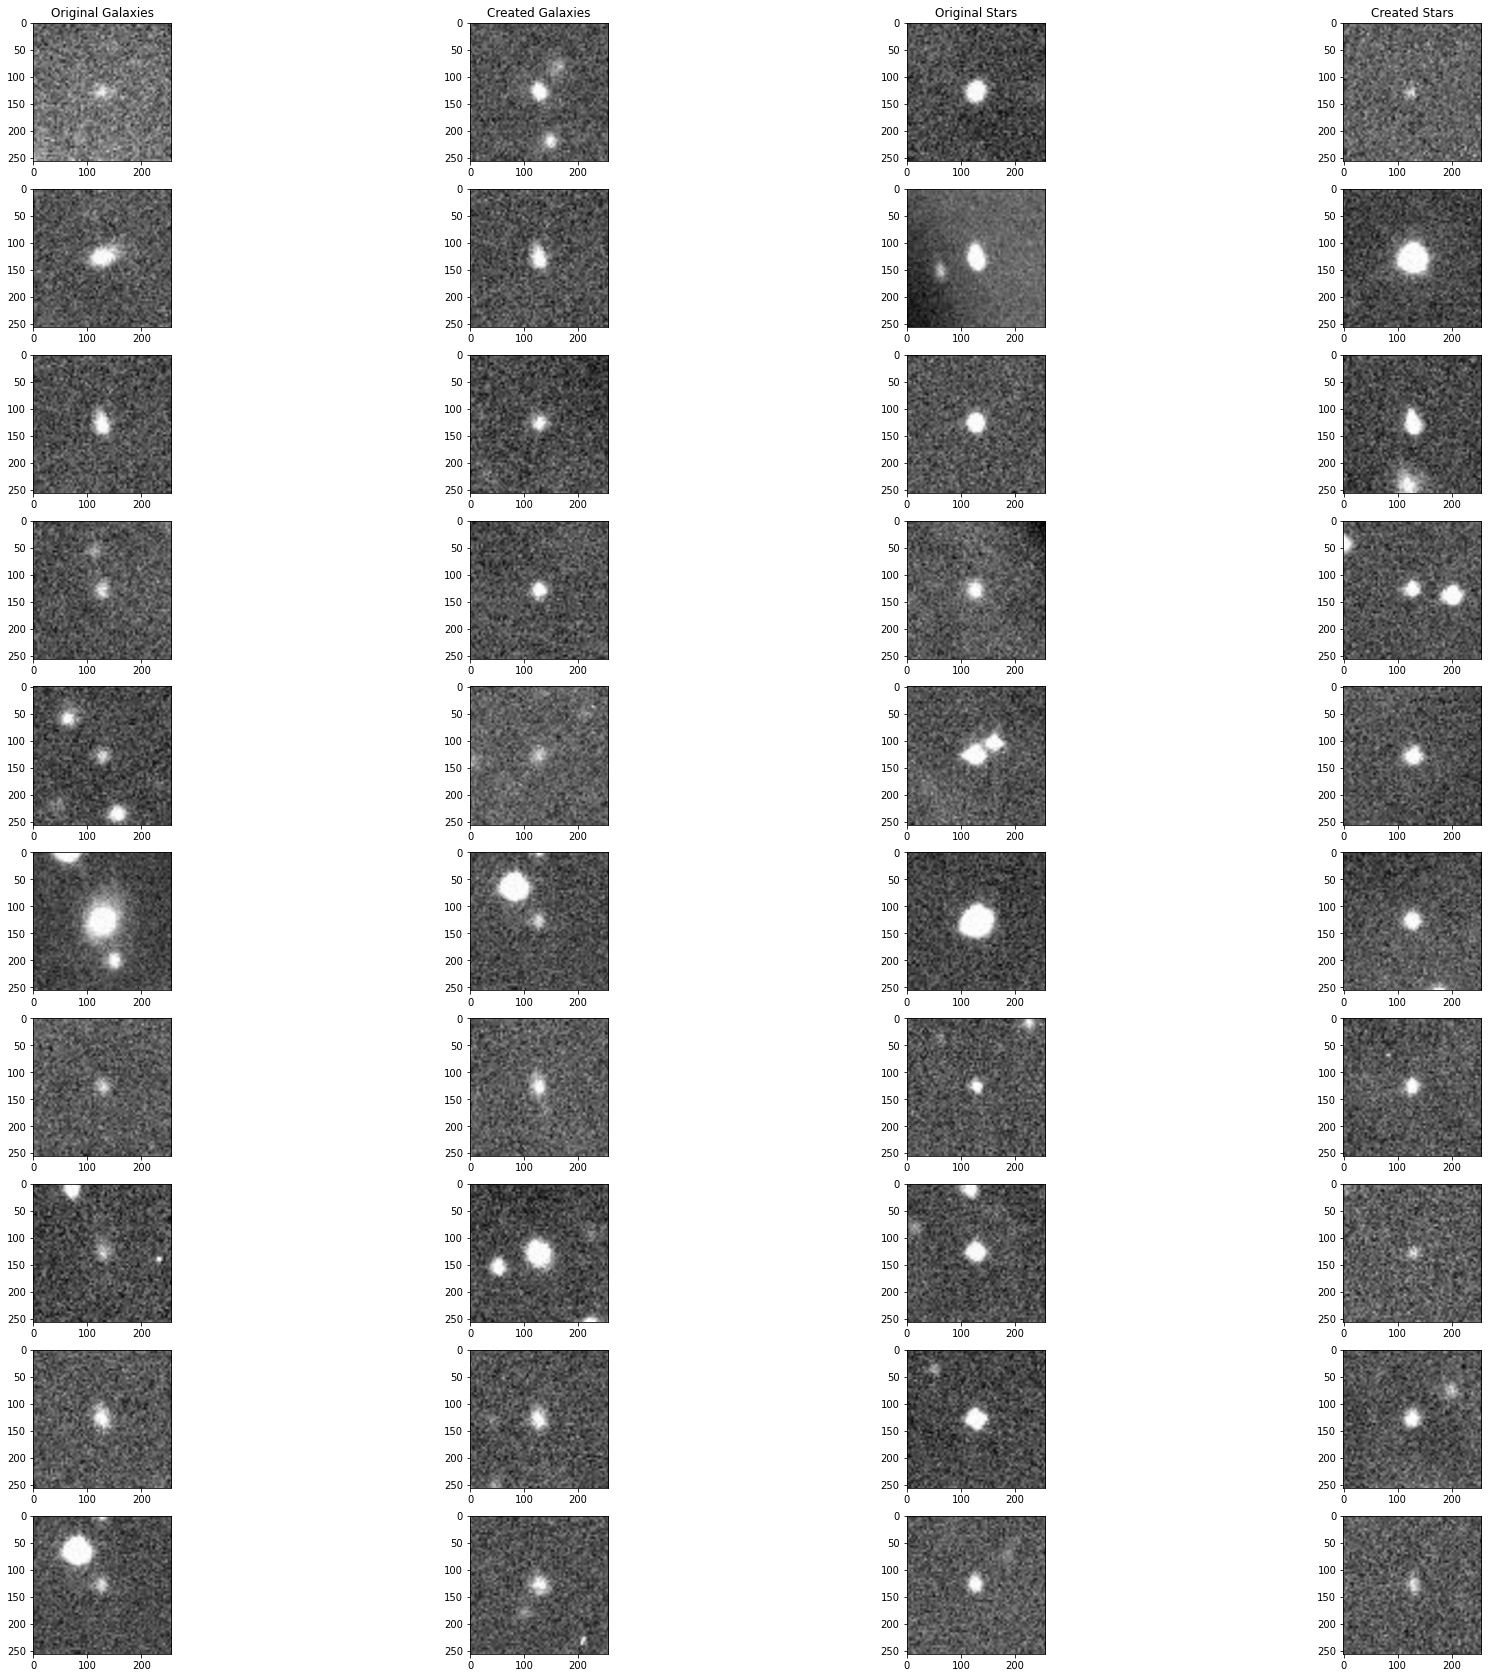

In [7]:
original_galaxies = []
augmented_galaxies = []
original_stars = []
augmented_stars = []
for batch in train:
  if len(original_galaxies) == 10 and len(original_stars) == 10:
    break
  for i in range(len(batch[0])):
    if len(original_galaxies) == 10 and len(original_stars) == 10:
      break
    if batch[1][i][0] == 1 and len(original_galaxies) != 10:
      original_galaxies.append(batch[0][i].numpy().astype('uint8'))
    if batch[1][i][0] == 0 and len(original_stars) != 10:
      original_stars.append(batch[0][i].numpy().astype('uint8'))
for batch in train_augmented:
  if len(augmented_galaxies) == 10 and len(augmented_stars) == 10:
    break
  for i in range(len(batch[0])):
    if len(augmented_galaxies) == 10 and len(augmented_stars) == 10:
      break
    if batch[1][i][0] == 1 and len(augmented_galaxies) != 10:
      augmented_galaxies.append(batch[0][i].numpy().astype('uint8'))
    if batch[1][i][0] == 0 and len(augmented_stars) != 10:
      augmented_stars.append(batch[0][i].numpy().astype('uint8'))
fig, ax = plt.subplots(10, 4, figsize = (30, 30))
for i in range(10):
  ax[i, 0].imshow(original_galaxies[i])
  ax[i, 1].imshow(augmented_galaxies[i])
  ax[i, 2].imshow(original_stars[i])
  ax[i, 3].imshow(augmented_stars[i])
ax[0, 0].set_title('Original Galaxies')
ax[0, 1].set_title('Created Galaxies')
ax[0, 2].set_title('Original Stars')
ax[0, 3].set_title('Created Stars')
plt.show()

In [8]:
train = train.concatenate(train_augmented)

In [9]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    recall = true_positives / (possible_positives + backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + backend.epsilon())
    return f1_val

In [10]:
metrics = ['accuracy',
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           f1_score]

# Model Implementation

**Base Models**

AlexNet skeleton

In [15]:
alexnet = models.Sequential()
alexnet.add(layers.Conv2D(96, 11, strides = (4, 4), activation = 'relu', input_shape = (256, 256, 3)))
alexnet.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet.add(layers.Conv2D(256, 5, activation = 'relu', padding = 'same'))
alexnet.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
alexnet.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet.add(layers.Flatten())
alexnet.add(layers.Dense(4096, activation = 'relu'))
alexnet.add(layers.Dense(2, activation = 'softmax'))

In [16]:
alexnet._name = 'AlexNet_skeleton'
alexnet.summary()

Model: "AlexNet_skeleton"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 384)       885120    
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 384)  

LeNet-5 skeleton

In [17]:
lenet = models.Sequential()
lenet.add(layers.Conv2D(6, 5, activation = 'tanh', input_shape = (256, 256, 3)))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Conv2D(16, 5, activation = 'tanh'))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Conv2D(120, 5, activation = 'tanh'))
lenet.add(layers.Flatten())
lenet.add(layers.Dense(84, activation = 'tanh'))
lenet.add(layers.Dense(2, activation = 'softmax'))

In [32]:
lenet._name = 'Lenet-5_skeleton'
lenet.summary()

Model: "Lenet-5_skeleton"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 252, 252, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 126, 126, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_12 (Conv2D)          (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 61, 61, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 57, 120)       48120     
                                                                 
 flatten_2 (Flatten)         (None, 389880)       

ResNet-50

In [19]:
resnet50 = tf.keras.applications.ResNet50(input_tensor = Input(shape = (256, 256, 3)))
predictions = layers.Dense(2, activation = 'softmax')(resnet50.layers[-2].output)
resnet50 = models.Model(inputs = resnet50.inputs, outputs = predictions)

102967424/102967424 [==============================] - 5s 0us/step


In [20]:
resnet50._name = 'ResNet-50'
resnet50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

GoogLeNet

In [21]:
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = (256, 256, 3),
                                                            include_top = False,
                                                            weights = None)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')
inputs = tf.keras.Input(shape = (256, 256, 3))
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
inception = tf.keras.Model(inputs, outputs)

In [22]:
inception._name = 'GoogLeNet'
inception.summary()

Model: "GoogLeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                         

**Experimental Models**

AlexNet with dropout

In [23]:
alexnet_dropout = models.Sequential()
alexnet_dropout.add(layers.Conv2D(96, 11, strides = (4, 4), activation = 'relu', input_shape = (256, 256, 3)))
alexnet_dropout.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_dropout.add(layers.Conv2D(256, 5, activation = 'relu', padding = 'same'))
alexnet_dropout.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_dropout.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet_dropout.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet_dropout.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
alexnet_dropout.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_dropout.add(layers.Flatten())
alexnet_dropout.add(layers.Dense(4096, activation = 'relu'))
alexnet_dropout.add(layers.Dropout(0.5))
alexnet_dropout.add(layers.Dense(2, activation = 'softmax'))

In [24]:
alexnet_dropout._name = 'AlexNet_with_dropout'
alexnet_dropout.summary()

Model: "AlexNet_with_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_110 (Conv2D)         (None, 14, 14, 384)       885120    
                                                                 
 conv2d_111 (Conv2D)         (None, 14, 14, 38

AlexNet with batch normalization

In [27]:
alexnet_batchnorm = models.Sequential()
alexnet_batchnorm.add(layers.Conv2D(96, 11, strides = (4, 4), activation = 'relu', input_shape = (256, 256, 3)))
alexnet_batchnorm.add(layers.BatchNormalization())
alexnet_batchnorm.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_batchnorm.add(layers.Conv2D(256, 5, activation = 'relu', padding = 'same'))
alexnet_batchnorm.add(layers.BatchNormalization())
alexnet_batchnorm.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_batchnorm.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet_batchnorm.add(layers.BatchNormalization())
alexnet_batchnorm.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet_batchnorm.add(layers.BatchNormalization())
alexnet_batchnorm.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
alexnet_batchnorm.add(layers.BatchNormalization())
alexnet_batchnorm.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_batchnorm.add(layers.Flatten())
alexnet_batchnorm.add(layers.Dense(4096, activation = 'relu'))
alexnet_batchnorm.add(layers.Dense(2, activation = 'softmax'))

In [28]:
alexnet_batchnorm._name = 'AlexNet_with_batch_normalization'
alexnet_batchnorm.summary()

Model: "AlexNet_with_batch_normalization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_99 (Bat  (None, 62, 62, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_119 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_100 (Ba  (None, 30, 30, 256)      1024      
 tchNormalization)                                               
                                  

AlexNet with dropout and batch normalization

In [29]:
alexnet_dropout_batchnorm = models.Sequential()
alexnet_dropout_batchnorm.add(layers.Conv2D(96, 11, strides = (4, 4), activation = 'relu', input_shape = (256, 256, 3)))
alexnet_dropout_batchnorm.add(layers.BatchNormalization())
alexnet_dropout_batchnorm.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_dropout_batchnorm.add(layers.Conv2D(256, 5, activation = 'relu', padding = 'same'))
alexnet_dropout_batchnorm.add(layers.BatchNormalization())
alexnet_dropout_batchnorm.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_dropout_batchnorm.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet_dropout_batchnorm.add(layers.BatchNormalization())
alexnet_dropout_batchnorm.add(layers.Conv2D(384, 3, activation = 'relu', padding = 'same'))
alexnet_dropout_batchnorm.add(layers.BatchNormalization())
alexnet_dropout_batchnorm.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
alexnet_dropout_batchnorm.add(layers.BatchNormalization())
alexnet_dropout_batchnorm.add(layers.MaxPool2D(3, strides = (2, 2)))
alexnet_dropout_batchnorm.add(layers.Flatten())
alexnet_dropout_batchnorm.add(layers.Dense(4096, activation = 'relu'))
alexnet_dropout_batchnorm.add(layers.Dropout(0.5))
alexnet_dropout_batchnorm.add(layers.Dense(2, activation = 'softmax'))

In [30]:
alexnet_dropout_batchnorm._name = 'AlexNet_with_dropout_and_batch_normalization'
alexnet_dropout_batchnorm.summary()

Model: "AlexNet_with_dropout_and_batch_normalization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_104 (Ba  (None, 62, 62, 96)       384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_124 (Conv2D)         (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_105 (Ba  (None, 30, 30, 256)      1024      
 tchNormalization)                                               
                      

LeNet-5 with Dropout

In [31]:
lenet_dropout = models.Sequential()
lenet_dropout.add(layers.Conv2D(6, 5, activation = 'tanh', input_shape = (256, 256, 3)))
lenet_dropout.add(layers.AveragePooling2D(2))
lenet_dropout.add(layers.Conv2D(16, 5, activation = 'tanh'))
lenet_dropout.add(layers.AveragePooling2D(2))
lenet_dropout.add(layers.Conv2D(120, 5, activation = 'tanh'))
lenet_dropout.add(layers.Flatten())
lenet_dropout.add(layers.Dense(84, activation = 'tanh'))
lenet_dropout.add(layers.Dropout(0.5))
lenet_dropout.add(layers.Dense(2, activation = 'softmax'))

In [72]:
lenet_dropout._name = 'Lenet-5_with_dropout'
lenet_dropout.summary()

Model: "Lenet-5_with_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 252, 252, 6)       456       
                                                                 
 average_pooling2d_11 (Avera  (None, 126, 126, 6)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_129 (Conv2D)         (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_12 (Avera  (None, 61, 61, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_130 (Conv2D)         (None, 57, 57, 120)       48120     
                                                                 
 flatten_7 (Flatten)         (None, 389880)   

Lenet-5 with batch normalization

In [33]:
lenet_batch_normalization = models.Sequential()
lenet_batch_normalization.add(layers.Conv2D(6, 5, activation = 'tanh', input_shape = (256, 256, 3)))
lenet_batch_normalization.add(layers.BatchNormalization())
lenet_batch_normalization.add(layers.AveragePooling2D(2))
lenet_batch_normalization.add(layers.Conv2D(16, 5, activation = 'tanh'))
lenet_batch_normalization.add(layers.BatchNormalization())
lenet_batch_normalization.add(layers.AveragePooling2D(2))
lenet_batch_normalization.add(layers.Conv2D(120, 5, activation = 'tanh'))
lenet_batch_normalization.add(layers.BatchNormalization())
lenet_batch_normalization.add(layers.Flatten())
lenet_batch_normalization.add(layers.Dense(84, activation = 'tanh'))
lenet_batch_normalization.add(layers.Dense(2, activation = 'softmax'))

In [36]:
lenet_batch_normalization._name = 'Lenet-5_with_batch_normalization'
lenet_batch_normalization.summary()

Model: "Lenet-5_with_batch_normalization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_131 (Conv2D)         (None, 252, 252, 6)       456       
                                                                 
 batch_normalization_109 (Ba  (None, 252, 252, 6)      24        
 tchNormalization)                                               
                                                                 
 average_pooling2d_13 (Avera  (None, 126, 126, 6)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_132 (Conv2D)         (None, 122, 122, 16)      2416      
                                                                 
 batch_normalization_110 (Ba  (None, 122, 122, 16)     64        
 tchNormalization)                                               
                                  

LeNet-5 with dropout and batch normalization

In [35]:
lenet_batch_normalization_and_dropout = models.Sequential()
lenet_batch_normalization_and_dropout.add(layers.Conv2D(6, 5, activation = 'tanh', input_shape = (256, 256, 3)))
lenet_batch_normalization_and_dropout.add(layers.BatchNormalization())
lenet_batch_normalization_and_dropout.add(layers.AveragePooling2D(2))
lenet_batch_normalization_and_dropout.add(layers.Conv2D(16, 5, activation = 'tanh'))
lenet_batch_normalization_and_dropout.add(layers.BatchNormalization())
lenet_batch_normalization_and_dropout.add(layers.AveragePooling2D(2))
lenet_batch_normalization_and_dropout.add(layers.Conv2D(120, 5, activation = 'tanh'))
lenet_batch_normalization_and_dropout.add(layers.BatchNormalization())
lenet_batch_normalization_and_dropout.add(layers.Flatten())
lenet_batch_normalization_and_dropout.add(layers.Dense(84, activation = 'tanh'))
lenet_batch_normalization_and_dropout.add(layers.Dropout(0.5))
lenet_batch_normalization_and_dropout.add(layers.Dense(2, activation = 'softmax'))

In [37]:
lenet_batch_normalization_and_dropout._name = 'Lenet-5_with_dropout_and_batch_normalization'
lenet_batch_normalization_and_dropout.summary()

Model: "Lenet-5_with_dropout_and_batch_normalization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, 252, 252, 6)       456       
                                                                 
 batch_normalization_112 (Ba  (None, 252, 252, 6)      24        
 tchNormalization)                                               
                                                                 
 average_pooling2d_15 (Avera  (None, 126, 126, 6)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_135 (Conv2D)         (None, 122, 122, 16)      2416      
                                                                 
 batch_normalization_113 (Ba  (None, 122, 122, 16)     64        
 tchNormalization)                                               
                      

ResNet-50 with ImageNet weights

In [38]:
resnet_base = tf.keras.applications.ResNet50(include_top = False,
                                             weights = 'imagenet')
resnet_base.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')
inputs = tf.keras.Input(shape = (256, 256, 3))
x = resnet_base(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
resnet50_imagenet = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 5s 0us/step


In [39]:
resnet50_imagenet._name = 'ResNet-50_with_ImageNet_weights'
resnet50_imagenet.summary()

Model: "ResNet-50_with_ImageNet_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
___________________

GoogLeNet with trainable ImageNet weights

In [40]:
base_model_with_trainable_imagenet = tf.keras.applications.inception_v3.InceptionV3(input_shape = (256, 256, 3),
                                                                                    include_top = False,
                                                                                    weights = 'imagenet')
base_model_with_trainable_imagenet.trainable = True
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')
inputs = tf.keras.Input(shape = (256, 256, 3))
z = preprocess_input(inputs)
z = base_model_with_trainable_imagenet(z)
z = global_average_layer(z)
z = tf.keras.layers.Dropout(0.2)(z)
outputs = prediction_layer(z)
inception_with_trainable_imagenet = tf.keras.Model(inputs, outputs)

87910968/87910968 [==============================] - 5s 0us/step


In [41]:
inception_with_trainable_imagenet._name = 'GoogLeNet_with_trainable_ImageNet_weights'
inception_with_trainable_imagenet.summary()

Model: "GoogLeNet_with_trainable_ImageNet_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                         

# Model Training

In [42]:
optim = tf.keras.optimizers.Adam(learning_rate = 0.01)

**Base Models**

AlexNet skeleton

In [43]:
alexnet.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
alexnet.fit(train, validation_data = valid, epochs = 5)

Epoch 1/5
150/150 [==============================] - 140s 872ms/step - loss: 782031.5000 - accuracy: 0.7531 - precision: 0.7531 - recall: 0.7531 - f1_score: 0.7531 - val_loss: 0.5288 - val_accuracy: 0.7788 - val_precision: 0.7788 - val_recall: 0.7788 - val_f1_score: 0.7787
Epoch 2/5
150/150 [==============================] - 21s 136ms/step - loss: 0.5543 - accuracy: 0.7590 - precision: 0.7590 - recall: 0.7590 - f1_score: 0.7590 - val_loss: 0.5394 - val_accuracy: 0.7713 - val_precision: 0.7713 - val_recall: 0.7713 - val_f1_score: 0.7712
Epoch 3/5
150/150 [==============================] - 22s 144ms/step - loss: 0.5532 - accuracy: 0.7606 - precision: 0.7606 - recall: 0.7606 - f1_score: 0.7606 - val_loss: 0.5474 - val_accuracy: 0.7650 - val_precision: 0.7650 - val_recall: 0.7650 - val_f1_score: 0.7650
Epoch 4/5
150/150 [==============================] - 22s 141ms/step - loss: 0.5529 - accuracy: 0.7608 - precision: 0.7608 - recall: 0.7608 - f1_score: 0.7608 - val_loss: 0.5470 - val_accurac

LeNet-5 skeleton

In [44]:
lenet.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
lenet.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
150/150 [==============================] - 21s 129ms/step - loss: 0.6183 - accuracy: 0.7381 - precision: 0.7412 - recall: 0.7412 - f1_score: 0.7381 - val_loss: 0.5318 - val_accuracy: 0.7788 - val_precision: 0.7788 - val_recall: 0.7788 - val_f1_score: 0.7787
Epoch 2/10
150/150 [==============================] - 22s 141ms/step - loss: 0.5667 - accuracy: 0.7592 - precision: 0.7592 - recall: 0.7592 - f1_score: 0.7592 - val_loss: 0.5540 - val_accuracy: 0.7575 - val_precision: 0.7575 - val_recall: 0.7575 - val_f1_score: 0.7575
Epoch 3/10
150/150 [==============================] - 21s 138ms/step - loss: 0.5678 - accuracy: 0.7598 - precision: 0.7598 - recall: 0.7598 - f1_score: 0.7598 - val_loss: 0.5405 - val_accuracy: 0.7738 - val_precision: 0.7738 - val_recall: 0.7738 - val_f1_score: 0.7737
Epoch 4/10
150/150 [==============================] - 22s 147ms/step - loss: 0.5624 - accuracy: 0.7621 - precision: 0.7621 - recall: 0.7621 - f1_score: 0.7621 - val_loss: 0.5498 - val_accuracy:

ResNet-50

In [45]:
resnet50.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
resnet50.fit(train, validation_data = valid, epochs = 20)

Epoch 1/20
150/150 [==============================] - 77s 456ms/step - loss: 0.6365 - accuracy: 0.7544 - precision: 0.7568 - recall: 0.7568 - f1_score: 0.7544 - val_loss: 106.7168 - val_accuracy: 0.7700 - val_precision: 0.7700 - val_recall: 0.7700 - val_f1_score: 0.7700
Epoch 2/20
150/150 [==============================] - 71s 471ms/step - loss: 0.3865 - accuracy: 0.8300 - precision: 0.8300 - recall: 0.8300 - f1_score: 0.8300 - val_loss: 19.3900 - val_accuracy: 0.7750 - val_precision: 0.7750 - val_recall: 0.7750 - val_f1_score: 0.7750
Epoch 3/20
150/150 [==============================] - 69s 454ms/step - loss: 0.3422 - accuracy: 0.8562 - precision: 0.8562 - recall: 0.8562 - f1_score: 0.8562 - val_loss: 2.2602 - val_accuracy: 0.7788 - val_precision: 0.7788 - val_recall: 0.7788 - val_f1_score: 0.7787
Epoch 4/20
150/150 [==============================] - 68s 453ms/step - loss: 0.3220 - accuracy: 0.8633 - precision: 0.8633 - recall: 0.8633 - f1_score: 0.8633 - val_loss: 1.4439 - val_accura

GoogLeNet

In [46]:
inception.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
inception.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
150/150 [==============================] - 67s 379ms/step - loss: 0.9761 - accuracy: 0.7527 - precision: 0.7695 - recall: 0.7695 - f1_score: 0.7527 - val_loss: 36343.4609 - val_accuracy: 0.7700 - val_precision: 0.7700 - val_recall: 0.7700 - val_f1_score: 0.7700
Epoch 2/10
150/150 [==============================] - 56s 369ms/step - loss: 0.6256 - accuracy: 0.7777 - precision: 0.7777 - recall: 0.7777 - f1_score: 0.7777 - val_loss: 33.9334 - val_accuracy: 0.6650 - val_precision: 0.6650 - val_recall: 0.6650 - val_f1_score: 0.6650
Epoch 3/10
150/150 [==============================] - 57s 374ms/step - loss: 0.4057 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - f1_score: 0.8421 - val_loss: 32.2457 - val_accuracy: 0.7663 - val_precision: 0.7663 - val_recall: 0.7663 - val_f1_score: 0.7662
Epoch 4/10
150/150 [==============================] - 57s 376ms/step - loss: 0.4176 - accuracy: 0.8238 - precision: 0.8238 - recall: 0.8238 - f1_score: 0.8237 - val_loss: 1.7926 - val_acc

**Experimental Models**

AlexNet with dropout

In [47]:
alexnet_dropout.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
alexnet_dropout.fit(train, validation_data = valid, epochs = 5)

Epoch 1/5
150/150 [==============================] - 21s 132ms/step - loss: 1516622976.0000 - accuracy: 0.6083 - precision: 0.6307 - recall: 0.6307 - f1_score: 0.6083 - val_loss: 34867.0508 - val_accuracy: 0.7775 - val_precision: 0.7775 - val_recall: 0.7775 - val_f1_score: 0.7775
Epoch 2/5
150/150 [==============================] - 20s 129ms/step - loss: 6501.5444 - accuracy: 0.6431 - precision: 0.6431 - recall: 0.6431 - f1_score: 0.6431 - val_loss: 118.7760 - val_accuracy: 0.7700 - val_precision: 0.7700 - val_recall: 0.7700 - val_f1_score: 0.7700
Epoch 3/5
150/150 [==============================] - 19s 126ms/step - loss: 59.6462 - accuracy: 0.6390 - precision: 0.6390 - recall: 0.6390 - f1_score: 0.6390 - val_loss: 3.3242 - val_accuracy: 0.7563 - val_precision: 0.7563 - val_recall: 0.7563 - val_f1_score: 0.7562
Epoch 4/5
150/150 [==============================] - 19s 127ms/step - loss: 9.3622 - accuracy: 0.6360 - precision: 0.6360 - recall: 0.6360 - f1_score: 0.6360 - val_loss: 2.6962 

AlexNet with batch normalization

In [48]:
alexnet_batchnorm.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
alexnet.fit(train, validation_data = valid, epochs = 5)

Epoch 1/5
150/150 [==============================] - 20s 128ms/step - loss: 0.5578 - accuracy: 0.7583 - precision: 0.7583 - recall: 0.7583 - f1_score: 0.7583 - val_loss: 0.5444 - val_accuracy: 0.7663 - val_precision: 0.7663 - val_recall: 0.7663 - val_f1_score: 0.7662
Epoch 2/5
150/150 [==============================] - 19s 127ms/step - loss: 0.5586 - accuracy: 0.7579 - precision: 0.7579 - recall: 0.7579 - f1_score: 0.7579 - val_loss: 0.5263 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 0.7812 - val_f1_score: 0.7812
Epoch 3/5
150/150 [==============================] - 20s 129ms/step - loss: 0.5537 - accuracy: 0.7600 - precision: 0.7600 - recall: 0.7600 - f1_score: 0.7600 - val_loss: 0.5389 - val_accuracy: 0.7713 - val_precision: 0.7713 - val_recall: 0.7713 - val_f1_score: 0.7712
Epoch 4/5
150/150 [==============================] - 19s 127ms/step - loss: 0.5542 - accuracy: 0.7606 - precision: 0.7606 - recall: 0.7606 - f1_score: 0.7606 - val_loss: 0.5393 - val_accuracy: 0.7

AlexNet with dropout and batch normalization

In [49]:
alexnet_dropout_batchnorm.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
alexnet.fit(train, validation_data = valid, epochs = 5)

Epoch 1/5
150/150 [==============================] - 19s 125ms/step - loss: 0.5591 - accuracy: 0.7571 - precision: 0.7571 - recall: 0.7571 - f1_score: 0.7571 - val_loss: 0.5259 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 0.7812 - val_f1_score: 0.7812
Epoch 2/5
150/150 [==============================] - 19s 125ms/step - loss: 0.5579 - accuracy: 0.7581 - precision: 0.7581 - recall: 0.7581 - f1_score: 0.7581 - val_loss: 0.5439 - val_accuracy: 0.7663 - val_precision: 0.7663 - val_recall: 0.7663 - val_f1_score: 0.7662
Epoch 3/5
150/150 [==============================] - 19s 126ms/step - loss: 0.5539 - accuracy: 0.7590 - precision: 0.7590 - recall: 0.7590 - f1_score: 0.7590 - val_loss: 0.5423 - val_accuracy: 0.7675 - val_precision: 0.7675 - val_recall: 0.7675 - val_f1_score: 0.7675
Epoch 4/5
150/150 [==============================] - 19s 126ms/step - loss: 0.5547 - accuracy: 0.7590 - precision: 0.7590 - recall: 0.7590 - f1_score: 0.7590 - val_loss: 0.5605 - val_accuracy: 0.7

LeNet-5 with dropout

In [50]:
lenet_dropout.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
lenet_dropout.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
150/150 [==============================] - 20s 124ms/step - loss: 0.7121 - accuracy: 0.7098 - precision: 0.7209 - recall: 0.7209 - f1_score: 0.7098 - val_loss: 0.5438 - val_accuracy: 0.7663 - val_precision: 0.7663 - val_recall: 0.7663 - val_f1_score: 0.7662
Epoch 2/10
150/150 [==============================] - 19s 124ms/step - loss: 0.5983 - accuracy: 0.7381 - precision: 0.7381 - recall: 0.7381 - f1_score: 0.7381 - val_loss: 0.5612 - val_accuracy: 0.7725 - val_precision: 0.7725 - val_recall: 0.7725 - val_f1_score: 0.7725
Epoch 3/10
150/150 [==============================] - 19s 124ms/step - loss: 0.5792 - accuracy: 0.7552 - precision: 0.7552 - recall: 0.7552 - f1_score: 0.7552 - val_loss: 0.5622 - val_accuracy: 0.7650 - val_precision: 0.7650 - val_recall: 0.7650 - val_f1_score: 0.7650
Epoch 4/10
150/150 [==============================] - 19s 124ms/step - loss: 0.6046 - accuracy: 0.7402 - precision: 0.7402 - recall: 0.7402 - f1_score: 0.7402 - val_loss: 0.5557 - val_accuracy:

LeNet-5 with batch normalization

In [51]:
lenet_batch_normalization.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
lenet_batch_normalization.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
150/150 [==============================] - 21s 130ms/step - loss: 0.6365 - accuracy: 0.7362 - precision: 0.7398 - recall: 0.7398 - f1_score: 0.7362 - val_loss: 0.7110 - val_accuracy: 0.2387 - val_precision: 0.2387 - val_recall: 0.2387 - val_f1_score: 0.2387
Epoch 2/10
150/150 [==============================] - 19s 127ms/step - loss: 0.5730 - accuracy: 0.7596 - precision: 0.7596 - recall: 0.7596 - f1_score: 0.7596 - val_loss: 0.5404 - val_accuracy: 0.7713 - val_precision: 0.7713 - val_recall: 0.7713 - val_f1_score: 0.7712
Epoch 3/10
150/150 [==============================] - 19s 127ms/step - loss: 0.5731 - accuracy: 0.7560 - precision: 0.7560 - recall: 0.7560 - f1_score: 0.7560 - val_loss: 1.9372 - val_accuracy: 0.2275 - val_precision: 0.2275 - val_recall: 0.2275 - val_f1_score: 0.2275
Epoch 4/10
150/150 [==============================] - 19s 127ms/step - loss: 0.5679 - accuracy: 0.7600 - precision: 0.7600 - recall: 0.7600 - f1_score: 0.7600 - val_loss: 1.3236 - val_accuracy:

LeNet-5 with dropout and batch normalization

In [52]:
lenet_batch_normalization_and_dropout.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
lenet_batch_normalization_and_dropout.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
150/150 [==============================] - 21s 129ms/step - loss: 0.6636 - accuracy: 0.7163 - precision: 0.7252 - recall: 0.7252 - f1_score: 0.7162 - val_loss: 0.5560 - val_accuracy: 0.7613 - val_precision: 0.7613 - val_recall: 0.7613 - val_f1_score: 0.7612
Epoch 2/10
150/150 [==============================] - 20s 127ms/step - loss: 0.5917 - accuracy: 0.7400 - precision: 0.7400 - recall: 0.7400 - f1_score: 0.7400 - val_loss: 0.5822 - val_accuracy: 0.7638 - val_precision: 0.7638 - val_recall: 0.7638 - val_f1_score: 0.7637
Epoch 3/10
150/150 [==============================] - 19s 126ms/step - loss: 0.5906 - accuracy: 0.7473 - precision: 0.7473 - recall: 0.7473 - f1_score: 0.7473 - val_loss: 0.5602 - val_accuracy: 0.7575 - val_precision: 0.7575 - val_recall: 0.7575 - val_f1_score: 0.7575
Epoch 4/10
150/150 [==============================] - 19s 126ms/step - loss: 0.5761 - accuracy: 0.7517 - precision: 0.7517 - recall: 0.7517 - f1_score: 0.7517 - val_loss: 0.6056 - val_accuracy:

ResNet-50 with ImageNet weights

In [53]:
resnet50_imagenet.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
resnet50_imagenet.fit(train, validation_data = valid, epochs = 20)

Epoch 1/20
150/150 [==============================] - 33s 195ms/step - loss: 1.2189 - accuracy: 0.8260 - precision: 0.8182 - recall: 0.8182 - f1_score: 0.8260 - val_loss: 0.4115 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750 - val_f1_score: 0.8750
Epoch 2/20
150/150 [==============================] - 29s 187ms/step - loss: 0.4084 - accuracy: 0.8519 - precision: 0.8519 - recall: 0.8519 - f1_score: 0.8519 - val_loss: 0.4035 - val_accuracy: 0.8562 - val_precision: 0.8562 - val_recall: 0.8562 - val_f1_score: 0.8562
Epoch 3/20
150/150 [==============================] - 29s 188ms/step - loss: 0.3299 - accuracy: 0.8685 - precision: 0.8685 - recall: 0.8685 - f1_score: 0.8685 - val_loss: 0.3774 - val_accuracy: 0.8587 - val_precision: 0.8587 - val_recall: 0.8587 - val_f1_score: 0.8587
Epoch 4/20
150/150 [==============================] - 29s 187ms/step - loss: 0.3383 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - f1_score: 0.8733 - val_loss: 0.2912 - val_accuracy:

ResNet-50 with ImageNet weights and fine-tuning

In [54]:
resnet_base.trainable = True
print('Number of layers in base of ResNet-50: ', len(resnet_base.layers))

Number of layers in base of ResNet-50:  175


In [55]:
for layer in resnet_base.layers[:len(resnet_base.layers) - 15]:
  layer.trainable = False

In [56]:
resnet50_imagenet.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
resnet50_imagenet.fit(train, validation_data = valid, epochs = 40, initial_epoch = 20)

Epoch 21/40
150/150 [==============================] - 36s 217ms/step - loss: 286567.1562 - accuracy: 0.6548 - precision: 0.6857 - recall: 0.6857 - f1_score: 0.6548 - val_loss: 2.1226 - val_accuracy: 0.7613 - val_precision: 0.7613 - val_recall: 0.7613 - val_f1_score: 0.7612
Epoch 22/40
150/150 [==============================] - 31s 206ms/step - loss: 8.0164 - accuracy: 0.6521 - precision: 0.6521 - recall: 0.6521 - f1_score: 0.6521 - val_loss: 1.9893 - val_accuracy: 0.7738 - val_precision: 0.7738 - val_recall: 0.7738 - val_f1_score: 0.7737
Epoch 23/40
150/150 [==============================] - 31s 205ms/step - loss: 4.3824 - accuracy: 0.6669 - precision: 0.6669 - recall: 0.6669 - f1_score: 0.6669 - val_loss: 0.9252 - val_accuracy: 0.7887 - val_precision: 0.7887 - val_recall: 0.7887 - val_f1_score: 0.7887
Epoch 24/40
150/150 [==============================] - 31s 203ms/step - loss: 2.8214 - accuracy: 0.6656 - precision: 0.6656 - recall: 0.6656 - f1_score: 0.6656 - val_loss: 0.8146 - val_

GoogLeNet with ImageNet weights

In [58]:
inception.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
inception.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
150/150 [==============================] - 65s 387ms/step - loss: 0.2713 - accuracy: 0.8900 - precision: 0.8734 - recall: 0.8734 - f1_score: 0.8900 - val_loss: 1.0548 - val_accuracy: 0.8175 - val_precision: 0.8175 - val_recall: 0.8175 - val_f1_score: 0.8175
Epoch 2/10
150/150 [==============================] - 56s 373ms/step - loss: 0.2694 - accuracy: 0.8865 - precision: 0.8865 - recall: 0.8865 - f1_score: 0.8865 - val_loss: 0.2347 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062 - val_f1_score: 0.9062
Epoch 3/10
150/150 [==============================] - 56s 371ms/step - loss: 0.2530 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - f1_score: 0.8987 - val_loss: 0.2689 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000 - val_f1_score: 0.9000
Epoch 4/10
150/150 [==============================] - 57s 374ms/step - loss: 0.2583 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - f1_score: 0.8983 - val_loss: 0.7092 - val_accuracy:

GoogLeNet with trainable ImageNet weights

In [59]:
inception_with_trainable_imagenet.compile(optimizer = optim, loss = losses.binary_crossentropy, metrics = metrics)
inception_with_trainable_imagenet.fit(train, validation_data = valid, epochs = 10)

Epoch 1/10
150/150 [==============================] - 63s 375ms/step - loss: 0.9418 - accuracy: 0.7554 - precision: 0.7516 - recall: 0.7516 - f1_score: 0.7554 - val_loss: 85041.7812 - val_accuracy: 0.2275 - val_precision: 0.2275 - val_recall: 0.2275 - val_f1_score: 0.2275
Epoch 2/10
150/150 [==============================] - 55s 364ms/step - loss: 0.6547 - accuracy: 0.7525 - precision: 0.7525 - recall: 0.7525 - f1_score: 0.7525 - val_loss: 1.9965 - val_accuracy: 0.7675 - val_precision: 0.7675 - val_recall: 0.7675 - val_f1_score: 0.7675
Epoch 3/10
150/150 [==============================] - 55s 364ms/step - loss: 0.6225 - accuracy: 0.7569 - precision: 0.7569 - recall: 0.7569 - f1_score: 0.7569 - val_loss: 1.4262 - val_accuracy: 0.7763 - val_precision: 0.7763 - val_recall: 0.7763 - val_f1_score: 0.7762
Epoch 4/10
150/150 [==============================] - 56s 367ms/step - loss: 0.6280 - accuracy: 0.7542 - precision: 0.7542 - recall: 0.7542 - f1_score: 0.7542 - val_loss: 0.6137 - val_accur

# Model Evaluation

**Base Models**

AlexNet skeleton

In [60]:
results = alexnet.evaluate(test)
print('Test accuracy:', results[1])

25/25 [==============================] - 69s 3s/step - loss: 0.5271 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.7812 - f1_score: 0.7831
Test accuracy: 0.7811704874038696


LeNet-5 skeleton

In [61]:
lenet_results = lenet.evaluate(test)
print('Test accuracy:', lenet_results[1])

25/25 [==============================] - 8s 62ms/step - loss: 0.5476 - accuracy: 0.7672 - precision: 0.7672 - recall: 0.7672 - f1_score: 0.7683
Test accuracy: 0.767175555229187


ResNet-50

In [62]:
results = resnet50.evaluate(test)
print('Test accuracy:', results[1])

25/25 [==============================] - 10s 151ms/step - loss: 0.5700 - accuracy: 0.8613 - precision: 0.8613 - recall: 0.8613 - f1_score: 0.8608
Test accuracy: 0.8613231778144836


GoogLeNet

In [63]:
inception_results = inception.evaluate(test)
print('Test accuracy:', inception_results[1])

25/25 [==============================] - 9s 136ms/step - loss: 37.8147 - accuracy: 0.7455 - precision: 0.7455 - recall: 0.7455 - f1_score: 0.7451
Test accuracy: 0.7455470561981201


**Experimental Models**

AlexNet with dropout

In [64]:
results = alexnet_dropout.evaluate(test)
print('Test accuracy:', results[1])

25/25 [==============================] - 8s 59ms/step - loss: 1.1484 - accuracy: 0.7684 - precision: 0.7684 - recall: 0.7684 - f1_score: 0.7706
Test accuracy: 0.7684478163719177


AlexNet with batch normalization

In [65]:
results = alexnet_batchnorm.evaluate(test)
print('Test accuracy:', results[1])

25/25 [==============================] - 9s 74ms/step - loss: 1.9421 - accuracy: 0.7672 - precision: 0.7678 - recall: 0.7678 - f1_score: 0.7674
Test accuracy: 0.767175555229187


AlexNet with dropout and batch normalization

In [66]:
results = alexnet_dropout_batchnorm.evaluate(test)
print('Test accuracy:', results[1])

25/25 [==============================] - 8s 60ms/step - loss: 0.7738 - accuracy: 0.6921 - precision: 0.7426 - recall: 0.7426 - f1_score: 0.6926
Test accuracy: 0.6921119689941406


LeNet-5 with dropout

In [67]:
lenet_dropout_results = lenet_dropout.evaluate(test)
print('Test accuracy:', lenet_dropout_results[1])

25/25 [==============================] - 7s 57ms/step - loss: 0.5403 - accuracy: 0.7710 - precision: 0.7710 - recall: 0.7710 - f1_score: 0.7731
Test accuracy: 0.7709923386573792


LeNet-5 with batch normalization

In [68]:
lenet_batch_normalization_results = lenet_batch_normalization.evaluate(test)
print('Test accuracy:', lenet_batch_normalization_results[1])

25/25 [==============================] - 7s 56ms/step - loss: 0.5413 - accuracy: 0.7710 - precision: 0.7710 - recall: 0.7710 - f1_score: 0.7731
Test accuracy: 0.7709923386573792


LeNet-5 with dropout and batch normalization

In [69]:
lenet_batch_normalization_and_dropout_results = lenet_batch_normalization_and_dropout.evaluate(test)
print('Test accuracy:', lenet_batch_normalization_and_dropout_results[1])

25/25 [==============================] - 7s 57ms/step - loss: 0.5884 - accuracy: 0.7710 - precision: 0.7710 - recall: 0.7710 - f1_score: 0.7692
Test accuracy: 0.7709923386573792


ResNet-50 with ImageNet weights and fine-tuning

In [70]:
results = resnet50_imagenet.evaluate(test)
print('Test accuracy:', results[1])

25/25 [==============================] - 9s 127ms/step - loss: 0.4394 - accuracy: 0.7875 - precision: 0.7875 - recall: 0.7875 - f1_score: 0.7874
Test accuracy: 0.7875317931175232


GoogLeNet with untrainable ImageNet weights

In [73]:
inception_with_imagenet_results = inception.evaluate(test)
print('Test accuracy:', inception_with_imagenet_results[1])

25/25 [==============================] - 8s 95ms/step - loss: 38.4141 - accuracy: 0.7341 - precision: 0.7341 - recall: 0.7341 - f1_score: 0.7378
Test accuracy: 0.7340967059135437


GoogLeNet with trainable ImageNet weights

In [74]:
inception_with_trainable_imagenet_results = inception_with_trainable_imagenet.evaluate(test)
print('Test accuracy:', inception_with_trainable_imagenet_results[1])

25/25 [==============================] - 8s 97ms/step - loss: 0.7205 - accuracy: 0.7761 - precision: 0.7761 - recall: 0.7761 - f1_score: 0.7761
Test accuracy: 0.7760814428329468
